# <h1 align = "center">JCIA Hackathon 2025</h1>
# <h1 align = "center">Tri Automatique des Prunes</h1>

<table align="center">
  <thead>
    <tr>
      <th>Noms</th>
      <th>Prenoms</th>
      <th>Email</th>
    </tr>
  </thead>
  <tbody bgcolor='green' align='center'>
    <tr>
      <td>LONTSI LAMBOU</td>
      <td>RONALDINO</td>
      <td>lontsilambou@gmail.com</td>
    </tr>
    <tr>
      <td>FETUE FOKO </td>
      <td>NATHANAEL</td>
      <td>nathanaelfetue1237@gmail.com</td>
    </tr>
     <tr>
      <td>TCHIAZE FOUOSSO</td>
      <td>ROMERO</td>
      <td>romerotchiazefouosso@gmail.com</td>
    </tr>
  </tbody>
</table>

# <h3 align = "center">Importation des bibliotheques</h3>

In [2]:
# 1. Importation des bibliothèques nécessaires
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob
import cv2
from tqdm import tqdm

# TensorFlow et Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from keras.utils import to_categorical

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


2025-04-17 15:43:57.320652: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 15:43:57.605610: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 15:43:57.605654: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 15:43:57.606810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 15:43:57.731735: I tensorflow/core/platform/cpu_feature_g

# <h3 align = "center">configuration du GPU SI DISPONIBLE</h3>

In [3]:
# Configuration pour utiliser le GPU si disponible
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-04-17 15:44:03.270620: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


# <h3 align = "center">Définir les paramètres</h3>

In [4]:
# Définir les paramètres
SEED = 32
IMG_SIZE = 324  # Taille d'image pour MobileNetV2
BATCH_SIZE = 16
EPOCHS = 15  # Nombre d'époques
LEARNING_RATE = 0.0001  # Taux d'apprentissage réduit

# 2. 

# <h3 align = "center">Exploration des données</h3>

In [18]:
# 2. Exploration des données
# 2.1 Chargement du fichier CSV
df = pd.read_csv('african_plums_dataset/organized_plums_data_new.csv')
print("Aperçu des données:")
print(df.head())
print("\nInformations sur le DataFrame:")
print(df.info())

Aperçu des données:
         Image ID      Label Defect Type
0  bruised_plum_1  defective     bruised
1  bruised_plum_2  defective     bruised
2  bruised_plum_3  defective     bruised
3  bruised_plum_4  defective     bruised
4  bruised_plum_5  defective     bruised

Informations sur le DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4507 entries, 0 to 4506
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image ID     4507 non-null   object
 1   Label        4507 non-null   object
 2   Defect Type  4507 non-null   object
dtypes: object(3)
memory usage: 105.8+ KB
None


In [19]:

# 2.2 Analyse de la distribution des classes
print("\nDistribution des classes:")
class_distribution = df['Defect Type'].value_counts()
print(class_distribution)

# Visualiser la distribution des classes
plt.figure(figsize=(12, 6))
class_counts = df['Defect Type'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution des classes de prunes')
plt.xlabel('Type de défaut')
plt.ylabel('Nombre d\'images')
plt.xticks(rotation=45)

# Ajouter les valeurs et pourcentages
total = len(df)
for i, v in enumerate(class_counts.values):
    percentage = v / total * 100
    plt.text(i, v + 30, f"{v}\n({percentage:.1f}%)", ha='center')

plt.tight_layout()
plt.savefig('class_distribution.png')
plt.close()



Distribution des classes:
Defect Type
unaffected    1721
unripe         826
spotted        759
rotten         720
bruised        319
cracked        162
Name: count, dtype: int64


In [20]:
# 3. Prétraitement des données
# 3.1 Définition des chemins d'accès et des classes
base_dir = 'african_plums_dataset/african_plums'

# Utiliser les classes exactes présentes dans les données
classes = ['unaffected', 'unripe', 'spotted', 'rotten', 'bruised', 'cracked']
print(f"\nClasses identifiées: {classes}")

# Distribution des classes
print("\nDistribution des classes:")
for cls in classes:
    count = df[df['Defect Type'] == cls].shape[0]
    print(f"{cls}: {count} images ({count/len(df)*100:.1f}%)")



Classes identifiées: ['unaffected', 'unripe', 'spotted', 'rotten', 'bruised', 'cracked']

Distribution des classes:
unaffected: 1721 images (38.2%)
unripe: 826 images (18.3%)
spotted: 759 images (16.8%)
rotten: 720 images (16.0%)
bruised: 319 images (7.1%)
cracked: 162 images (3.6%)


In [21]:
# 3.2 Vérification de l'existence des dossiers et comptage des images
image_counts = {}
for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    if os.path.exists(cls_path):
        image_counts[cls] = len(os.listdir(cls_path))
    else:
        print(f"Le dossier pour la classe {cls} n'existe pas: {cls_path}")
        image_counts[cls] = 0

print("\nNombre d'images par classe:")
for cls, count in image_counts.items():
    print(f"{cls}: {count} images")



Nombre d'images par classe:
unaffected: 1721 images
unripe: 826 images
spotted: 759 images
rotten: 720 images
bruised: 319 images
cracked: 162 images


# <h3 align = "center">Fonction de prétraitement pour les images</h3>

In [22]:
# 3.3 Fonction de prétraitement pour les images
# Fonction personnalisée pour le prétraitement
def preprocess_image(img):
    try:
        # Vérifier le type et la forme de l'image d'entrée
        if isinstance(img, str):
            print(f"Erreur: img est une chaîne de caractères: {img}")
            # Créer une image noire à la place
            return np.zeros((IMG_SIZE, IMG_SIZE, 3))
        
        if img is None:
            print("Erreur: img est None")
            return np.zeros((IMG_SIZE, IMG_SIZE, 3))
        
        # Convertir en RGB si nécessaire
        if len(img.shape) == 2:  # Image en niveaux de gris
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[-1] == 4:  # Image RGBA
            img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
        elif img.shape[-1] != 3:  # Autre format
            print(f"Format d'image non standard: {img.shape}")
            # Créer une image RGB à partir des données
            if len(img.shape) > 2:
                img = img[:, :, :3]  # Prendre les 3 premiers canaux
            else:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        # S'assurer que l'image est au format uint8
        if img.dtype != np.uint8:
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)
        
        # Appliquer des traitements simples
        # Redimensionner
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        
        # Normaliser les valeurs de pixel
        img = img / 255.0
        
        return img
    
    except Exception as e:
        print(f"Erreur dans preprocess_image: {e}")
        # En cas d'erreur, retourner une image noire
        return np.zeros((IMG_SIZE, IMG_SIZE, 3))


# <h3 align = "center">FONCTION POUR L'AUGMENTATION DES DONNEES </h3>

In [23]:
# 4. Préparation des données pour le modèle
# 4.1 Division des données en ensembles d'entraînement, validation et test (70-15-15)
from sklearn.model_selection import train_test_split

# Définir le générateur principal sans division validation intégrée
# Augmentation plus agressive pour les classes minoritaires
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=30,                # Augmenter à 30 degrés
    width_shift_range=0.3,            # Augmenter à 0.3
    height_shift_range=0.3,           # Augmenter à 0.3
    shear_range=0.3,                  # Augmenter à 0.3
    zoom_range=0.3,                   # Augmenter à 0.3
    horizontal_flip=True,
    vertical_flip=True,               # Ajouter le retournement vertical
    brightness_range=[0.7, 1.3],      # Ajouter variation de luminosité
    fill_mode='nearest'
)

# Générateur pour validation et test (sans augmentation)
eval_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image
)

# Obtenir toutes les images et leurs classes
import glob
image_paths = []
image_classes = []

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    if os.path.exists(cls_path):
        for img_file in glob.glob(os.path.join(cls_path, '*.jpg')) + \
                        glob.glob(os.path.join(cls_path, '*.png')) + \
                        glob.glob(os.path.join(cls_path, '*.jpeg')):
            image_paths.append(img_file)
            image_classes.append(cls)

# Créer un DataFrame pour faciliter la division
image_df = pd.DataFrame({
    'path': image_paths,
    'class': image_classes
})

# Vérifier la distribution des classes dans le dataset complet
print("\nDistribution des classes dans le dataset complet:")
print(image_df['class'].value_counts())



Distribution des classes dans le dataset complet:
class
unaffected    1721
unripe         826
spotted        759
rotten         720
bruised        319
cracked        162
Name: count, dtype: int64


# <h3 align = "center">Division des données en ensembles d'entraînement, validation et test (70-15-15)</h3>

In [24]:
# Première division : 85% pour train+validation, 15% pour test
train_val_df, test_df = train_test_split(
    image_df, 
    test_size=0.15, 
    stratify=image_df['class'],
    random_state=SEED
)

# Deuxième division : diviser train_val_df en 82.35% train (70% du total) et 17.65% validation (15% du total)
train_df, val_df = train_test_split(
    train_val_df, 
    test_size=0.1765,  # 15/85 = 0.1765
    stratify=train_val_df['class'],
    random_state=SEED
)

print(f"\nRépartition des données:")
print(f"Entraînement: {len(train_df)} images ({len(train_df)/len(image_df)*100:.1f}%)")
print(f"Validation: {len(val_df)} images ({len(val_df)/len(image_df)*100:.1f}%)")
print(f"Test: {len(test_df)} images ({len(test_df)/len(image_df)*100:.1f}%)")

# Vérifier la distribution des classes dans chaque ensemble
print("\nDistribution des classes dans l'ensemble d'entraînement:")
print(train_df['class'].value_counts())
print("\nDistribution des classes dans l'ensemble de validation:")
print(val_df['class'].value_counts())
print("\nDistribution des classes dans l'ensemble de test:")
print(test_df['class'].value_counts())



Répartition des données:
Entraînement: 3154 images (70.0%)
Validation: 676 images (15.0%)
Test: 677 images (15.0%)

Distribution des classes dans l'ensemble d'entraînement:
class
unaffected    1204
unripe         578
spotted        531
rotten         504
bruised        223
cracked        114
Name: count, dtype: int64

Distribution des classes dans l'ensemble de validation:
class
unaffected    258
unripe        124
spotted       114
rotten        108
bruised        48
cracked        24
Name: count, dtype: int64

Distribution des classes dans l'ensemble de test:
class
unaffected    259
unripe        124
spotted       114
rotten        108
bruised        48
cracked        24
Name: count, dtype: int64


# <h3 align = "center"> Équilibrer les classes par surreprésentation des classes minoritaires avec l'augmentation 
</h3>

In [25]:
# 4.2 Gestion du déséquilibre des classes dans l'ensemble d'entraînement
# Équilibrer les classes par surreprésentation des classes minoritaires

# Déterminer la taille de la classe majoritaire
max_class_count = train_df['class'].value_counts().max()

# Préparer un DataFrame équilibré
balanced_train_df = train_df.copy()

# Pour chaque classe minoritaire, ajouter des copies jusqu'à atteindre la taille de la classe majoritaire
for cls, count in train_df['class'].value_counts().items():
    if count < max_class_count:
        # Calculer combien d'échantillons supplémentaires sont nécessaires
        samples_to_add = max_class_count - count
        
        # Obtenir les échantillons de cette classe
        class_samples = train_df[train_df['class'] == cls]
        
        # Ajouter des copies (avec remplacement si nécessaire)
        additional_samples = class_samples.sample(n=samples_to_add, replace=True, random_state=SEED)
        
        # Combiner avec le DataFrame équilibré
        balanced_train_df = pd.concat([balanced_train_df, additional_samples])

print("\nTaille du dataset d'entraînement après équilibrage:", len(balanced_train_df))
print("Distribution des classes après équilibrage:")
print(balanced_train_df['class'].value_counts())



Taille du dataset d'entraînement après équilibrage: 7224
Distribution des classes après équilibrage:
class
unaffected    1204
rotten        1204
spotted       1204
cracked       1204
unripe        1204
bruised       1204
Name: count, dtype: int64


In [30]:
# 4.3 Création des générateurs pour l'entraînement et l'évaluation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=balanced_train_df,
    directory=None,  # Les chemins complets sont déjà dans 'path'
    x_col='path',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

validation_generator = eval_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col='path',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

test_generator = eval_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='path',
    y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=SEED
)

# Vérifier les indices de classes
print("\nIndices des classes:")
class_indices = train_generator.class_indices
print(class_indices)


Found 7224 validated image filenames belonging to 6 classes.
Found 676 validated image filenames belonging to 6 classes.
Found 677 validated image filenames belonging to 6 classes.

Indices des classes:
{'bruised': 0, 'cracked': 1, 'rotten': 2, 'spotted': 3, 'unaffected': 4, 'unripe': 5}


In [31]:
# Correspondance indices-noms pour l'évaluation
class_names = list(class_indices.keys())


# <h2 align = "center">phase d'entrainement</h2>

# <h3 align = "center"> Chargement du modèle pré-entraîné (MobileNetV2) </h3>

In [32]:
# 5. Construction du modèle
from tensorflow.keras.regularizers import l1_l2,l2
# 5.1 Chargement du modèle pré-entraîné (MobileNetV2)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = l2(0.00005)

# 5.2 Ajout des couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization(momentum=0.9)(x)  # Ajout de la normalisation par lots
x = Dropout(0.6)(x)
x = Dense(128, activation='relu',kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(x)
x = BatchNormalization(momentum=0.9)(x)  # Ajout de la normalisation par lots
x = Dropout(0.4)(x)
predictions = Dense(len(class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


# <h3 align = "center">Compilation du  et Utilisation de Focal Loss pour mieux gérer les classes déséquilibrées</h3>

In [33]:
# 5.3 Gel des couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# 6. Compilation et entraînement du modèle
# 6.1 Compilation avec fonction de perte adaptée et taux d'apprentissage réduit
# Utilisation de Focal Loss pour mieux gérer les classes déséquilibrées
focal_loss = CategoricalFocalCrossentropy(gamma=2.0)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss=focal_loss,  # Remplace 'categorical_crossentropy'
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']  # Métriques supplémentaires
)


In [34]:
# 6.2 Définition des callbacks
checkpoint = ModelCheckpoint(
    'best_plum_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # Augmentation de la patience
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]


# <h3 align = "center"> Calcul des poids de classes pour gérer le déséquilibre </h3>

In [35]:
# 6.3 Calcul des poids de classes pour gérer le déséquilibre
class_weights = {}
train_class_counts = np.bincount(train_generator.classes)
total_samples = train_generator.samples

for i, count in enumerate(train_class_counts):
    if count > 0:
        if class_names[i] in ['bruised', 'cracked']:
            # Pénaliser plus fortement les erreurs sur les classes minoritaires
            class_weights[i] = (total_samples / (len(train_class_counts) * count)) ** 1.5
        else:
            class_weights[i] = (total_samples / (len(train_class_counts) * count)) ** 1.0
    else:
        class_weights[i] = 1.0

print("\nPoids des classes pour l'entraînement:")
for i, cls in enumerate(train_generator.class_indices.keys()):
    print(f"{cls} (indice {i}): {class_weights[i]:.4f}")

# Visualiser les poids de classes
plt.figure(figsize=(10, 6))
class_labels = list(train_generator.class_indices.keys())
weights = [class_weights[i] for i in range(len(class_labels))]
sns.barplot(x=class_labels, y=weights)
plt.title('Poids appliqués à chaque classe pour compenser le déséquilibre')
plt.xlabel('Classe')
plt.ylabel('Poids')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('class_weights.png')
plt.close()



Poids des classes pour l'entraînement:
bruised (indice 0): 1.0000
cracked (indice 1): 1.0000
rotten (indice 2): 1.0000
spotted (indice 3): 1.0000
unaffected (indice 4): 1.0000
unripe (indice 5): 1.0000


In [36]:
# 6.4 Affichage du résumé du modèle
print("\nRésumé de l'architecture du modèle:")
model.summary()



Résumé de l'architecture du modèle:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 324, 324, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 162, 162, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 162, 162, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 162, 162, 32)        

# <h3 align = "center"> Première phase d'entraînement - uniquement les couches supérieures</h3>

In [20]:
# 7. Fine-tuning du modèle
# 7.1 Première phase d'entraînement - uniquement les couches supérieures

print("\nDébut de l'entraînement initial...")
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=75,  # Première phase d'entraînement
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Début de l'entraînement initial...
Epoch 1/75
225/225 [==============================] - ETA: 0s - loss: 1.9614 - accuracy: 0.1882 - auc: 0.5313 - precision: 0.1993 - recall: 0.1141
Epoch 1: val_accuracy improved from -inf to 0.24330, saving model to best_plum_model.h5


/home/lontsi/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


225/225 [==============================] - 107s 468ms/step - loss: 1.9614 - accuracy: 0.1882 - auc: 0.5313 - precision: 0.1993 - recall: 0.1141 - val_loss: 1.6163 - val_accuracy: 0.2433 - val_auc: 0.6041 - val_precision: 0.3251 - val_recall: 0.0882 - lr: 1.0000e-04
Epoch 2/75
225/225 [==============================] - ETA: 0s - loss: 1.8767 - accuracy: 0.2258 - auc: 0.5823 - precision: 0.2403 - recall: 0.1350
Epoch 2: val_accuracy improved from 0.24330 to 0.26786, saving model to best_plum_model.h5
225/225 [==============================] - 114s 508ms/step - loss: 1.8767 - accuracy: 0.2258 - auc: 0.5823 - precision: 0.2403 - recall: 0.1350 - val_loss: 1.5860 - val_accuracy: 0.2679 - val_auc: 0.6386 - val_precision: 0.3480 - val_recall: 0.1060 - lr: 1.0000e-04
Epoch 3/75
225/225 [==============================] - ETA: 0s - loss: 1.7886 - accuracy: 0.2742 - auc: 0.6263 - precision: 0.3164 - recall: 0.1818
Epoch 3: val_accuracy improved from 0.26786 to 0.29688, saving model to best_plum_m

# <h3 align = "center">Premier fine-tuning: dégel des dernières couches du modèle de base</h3>

In [21]:
# 7.2 Premier fine-tuning: dégel des dernières couches du modèle de base
print("\nDébut du premier fine-tuning...")
# Dégeler les derniers blocs du MobileNetV2
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Recompiler avec un taux d'apprentissage plus faible
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE / 10),
    loss=focal_loss,
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

# Premier fine-tuning
fine_tuning_history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=35,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)


Début du premier fine-tuning...
Epoch 1/35
225/225 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.4736 - auc: 0.8045 - precision: 0.6153 - recall: 0.2659
Epoch 1: val_accuracy did not improve from 0.51004
225/225 [==============================] - 143s 623ms/step - loss: 0.6299 - accuracy: 0.4736 - auc: 0.8045 - precision: 0.6153 - recall: 0.2659 - val_loss: 0.7065 - val_accuracy: 0.4743 - val_auc: 0.8227 - val_precision: 0.5339 - val_recall: 0.4219 - lr: 1.0000e-05
Epoch 2/35
225/225 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.5070 - auc: 0.8250 - precision: 0.6510 - recall: 0.2965
Epoch 2: val_accuracy did not improve from 0.51004
225/225 [==============================] - 140s 623ms/step - loss: 0.6122 - accuracy: 0.5070 - auc: 0.8250 - precision: 0.6510 - recall: 0.2965 - val_loss: 0.6457 - val_accuracy: 0.4967 - val_auc: 0.8360 - val_precision: 0.5565 - val_recall: 0.4286 - lr: 1.0000e-05
Epoch 3/35
225/225 [===================

# <h3 align = "center">Deuxième fine-tuning: dégel complet</h3>

In [ ]:
# 7.3 Deuxième fine-tuning: dégel complet
print("\nDébut du deuxième fine-tuning avec modèle complètement dégelé...")
# Dégeler tous les layers du modèle de base
for layer in base_model.layers:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE ),
    loss=focal_loss,
    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
)

# Deuxième fine-tuning
fine_tuning_history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=25,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)



Début du deuxième fine-tuning avec modèle complètement dégelé...
Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.5223 - auc: 0.8370 - precision: 0.6516 - recall: 0.3260
Epoch 1: val_accuracy did not improve from 0.56362
225/225 [==============================] - 309s 1s/step - loss: 0.5988 - accuracy: 0.5223 - auc: 0.8370 - precision: 0.6516 - recall: 0.3260 - val_loss: 0.5803 - val_accuracy: 0.4821 - val_auc: 0.8133 - val_precision: 0.6152 - val_recall: 0.3426 - lr: 1.0000e-04
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.5467 - accuracy: 0.5604 - auc: 0.8634 - precision: 0.7025 - recall: 0.3544
Epoch 2: val_accuracy did not improve from 0.56362
225/225 [==============================] - 304s 1s/step - loss: 0.5467 - accuracy: 0.5604 - auc: 0.8634 - precision: 0.7025 - recall: 0.3544 - val_loss: 0.5890 - val_accuracy: 0.4821 - val_auc: 0.8150 - val_precision: 0.6011 - val_recall: 0.3683 - lr: 1.0000e-04
Epoch 3/25
2

# <h3 align = "center"> Évaluation sur l'ensemble de validation </h3>

In [25]:
# 7.4 Évaluation sur l'ensemble de validation
print("\nÉvaluation du modèle sur l'ensemble de validation:")
model.load_weights('best_plum_model.h5')  # Charger le meilleur modèle
validation_results = model.evaluate(validation_generator)
print(f"Résultats sur l'ensemble de validation:")
print(f"Loss: {validation_results[0]:.4f}")
print(f"Accuracy: {validation_results[1]:.4f}")
print(f"AUC: {validation_results[2]:.4f}")
print(f"Precision: {validation_results[3]:.4f}")
print(f"Recall: {validation_results[4]:.4f}")



Évaluation du modèle sur l'ensemble de validation:
57/57 [==============================] - 18s 306ms/step - loss: 0.2500 - accuracy: 0.5973 - auc: 0.8772 - precision: 0.6360 - recall: 0.5462
Résultats sur l'ensemble de validation:
Loss: 0.2500
Accuracy: 0.5973
AUC: 0.8772
Precision: 0.6360
Recall: 0.5462


# <h3 align = "center"> Évaluation sur l'ensemble de test </h3>

In [26]:
# 8. Évaluation sur l'ensemble de test
# 8.1 Après le fine-tuning complet, évaluer sur l'ensemble de test indépendant

print("\nÉvaluation finale sur l'ensemble de test (données non vues pendant l'entraînement):")
model.load_weights('best_plum_model.h5')  # Charger le meilleur modèle
test_results = model.evaluate(test_generator)

print(f"Résultats sur l'ensemble de test:")
print(f"Loss: {test_results[0]:.4f}")
print(f"Accuracy: {test_results[1]:.4f}")
print(f"AUC: {test_results[2]:.4f}")
print(f"Precision: {test_results[3]:.4f}")
print(f"Recall: {test_results[4]:.4f}")

# 8.2 Matrice de confusion et rapport de classification détaillé
y_pred = []
y_true = []

# Prédire sur l'ensemble de test
for i in range(len(test_generator)):
    if i >= test_generator.samples // BATCH_SIZE + (1 if test_generator.samples % BATCH_SIZE > 0 else 0):
        break
    X, y = next(test_generator)
    y_pred.extend(np.argmax(model.predict(X), axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Création du rapport de classification
print("\nRapport de classification sur l'ensemble de test:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion sur l\'ensemble de test')
plt.ylabel('Vérité terrain')
plt.xlabel('Prédiction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('confusion_matrix_test.png')
plt.close()



Évaluation finale sur l'ensemble de test (données non vues pendant l'entraînement):
43/43 [==============================] - 10s 221ms/step - loss: 0.1098 - accuracy: 0.8419 - auc: 0.9712 - precision: 0.8641 - recall: 0.8168
Résultats sur l'ensemble de test:
Loss: 0.1098
Accuracy: 0.8419
AUC: 0.9712
Precision: 0.8641
Recall: 0.8168
1/1 [==============================] - 0s 99ms/step

Rapport de classification sur l'ensemble de test:
              precision    recall  f1-score   support

     bruised       0.72      0.81      0.76        48
     cracked       0.65      1.00      0.79        24
      rotten       0.98      0.87      0.92       108
     spotted       0.65      0.84      0.74       114
  unaffected       0.93      0.83      0.88       259
      unripe       0.92      0.82      0.87       124

    accuracy                           0.84       677
   macro avg       0.81      0.86      0.83       677
weighted avg       0.86      0.84      0.85       677



In [ ]:
# Visualiser l'historique d'entraînement complet
combined_history_list = [history, fine_tuning_history1, fine_tuning_history2]

# <h3 align = "center">visualisation des courbe d'entrainement </h3>

/tmp/ipykernel_5999/284100020.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return pd.Series(points).rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill').values


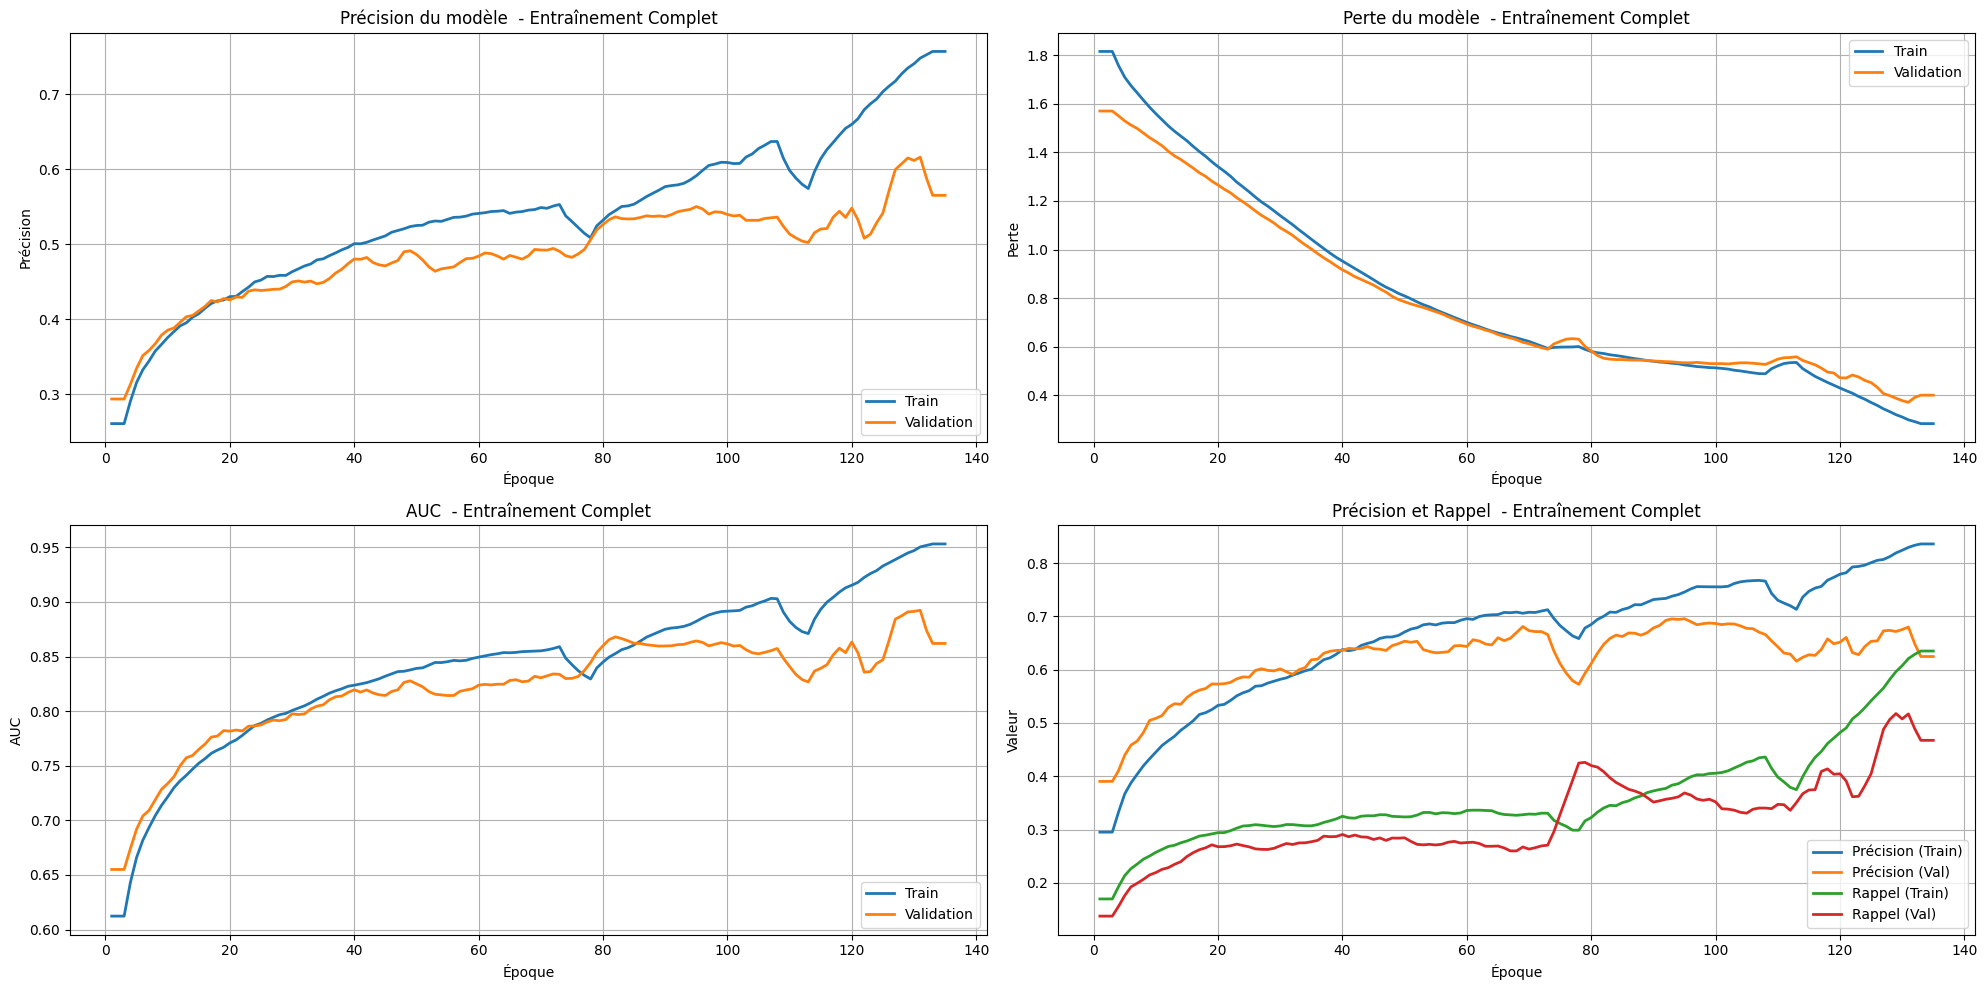

In [29]:
def plot_smooth_training_history(history, title_suffix="", window_size=5, show=True):
    plt.figure(figsize=(20, 10))
    
    # Préparation des données
    combined_history = {}
    if isinstance(history, list):
        combined_epochs = 0
        for h in history:
            for metric in h.history.keys():
                if metric not in combined_history:
                    combined_history[metric] = []
                combined_history[metric].extend(h.history[metric])
            combined_epochs += len(h.history['accuracy'])
        epochs_range = range(1, combined_epochs + 1)
    else:
        combined_history = history.history
        epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    # Fonction de lissage
    def smooth_curve(points):
        return pd.Series(points).rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill').values
    
    # Précision
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, smooth_curve(combined_history['accuracy']), label='Train', linewidth=2)
    plt.plot(epochs_range, smooth_curve(combined_history['val_accuracy']), label='Validation', linewidth=2)
    plt.title(f'Précision du modèle {title_suffix}')
    plt.ylabel('Précision')
    plt.xlabel('Époque')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Perte
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, smooth_curve(combined_history['loss']), label='Train', linewidth=2)
    plt.plot(epochs_range, smooth_curve(combined_history['val_loss']), label='Validation', linewidth=2)
    plt.title(f'Perte du modèle {title_suffix}')
    plt.ylabel('Perte')
    plt.xlabel('Époque')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    # AUC
    if 'auc' in combined_history:
        plt.subplot(2, 2, 3)
        plt.plot(epochs_range, smooth_curve(combined_history['auc']), label='Train', linewidth=2)
        plt.plot(epochs_range, smooth_curve(combined_history['val_auc']), label='Validation', linewidth=2)
        plt.title(f'AUC {title_suffix}')
        plt.ylabel('AUC')
        plt.xlabel('Époque')
        plt.legend(loc='lower right')
        plt.grid(True)
    
    # Précision et Rappel
    if 'precision' in combined_history and 'recall' in combined_history:
        plt.subplot(2, 2, 4)
        plt.plot(epochs_range, smooth_curve(combined_history['precision']), label='Précision (Train)', linewidth=2)
        plt.plot(epochs_range, smooth_curve(combined_history['val_precision']), label='Précision (Val)', linewidth=2)
        plt.plot(epochs_range, smooth_curve(combined_history['recall']), label='Rappel (Train)', linewidth=2)
        plt.plot(epochs_range, smooth_curve(combined_history['val_recall']), label='Rappel (Val)', linewidth=2)
        plt.title(f'Précision et Rappel {title_suffix}')
        plt.ylabel('Valeur')
        plt.xlabel('Époque')
        plt.legend(loc='lower right')
        plt.grid(True)
    
    plt.tight_layout()
    
    # Enregistrer l'image
    plt.savefig(f'smooth_training_history{title_suffix.replace(" ", "_")}.png', dpi=300)
    
    # Afficher l'image au lieu de la fermer si demandé
    if show:
        plt.show()
    else:
        plt.close()

# Utilisation dans le notebook:
plot_smooth_training_history(combined_history_list, title_suffix=" - Entraînement Complet")

# <h3 align = "center">Matrice de confusion </h3>

1/1 [==============================] - 0s 75ms/step
Précision par classe:
bruised:
  - Précision: 0.7222
  - Rappel: 0.8125
  - F1-score: 0.7647
  - Support: 48.0 échantillons

cracked:
  - Précision: 0.6486
  - Rappel: 1.0000
  - F1-score: 0.7869
  - Support: 24.0 échantillons

rotten:
  - Précision: 0.9792
  - Rappel: 0.8704
  - F1-score: 0.9216
  - Support: 108.0 échantillons

spotted:
  - Précision: 0.6531
  - Rappel: 0.8421
  - F1-score: 0.7356
  - Support: 114.0 échantillons

unaffected:
  - Précision: 0.9267
  - Rappel: 0.8301
  - F1-score: 0.8758
  - Support: 259.0 échantillons

unripe:
  - Précision: 0.9189
  - Rappel: 0.8226
  - F1-score: 0.8681
  - Support: 124.0 échantillons



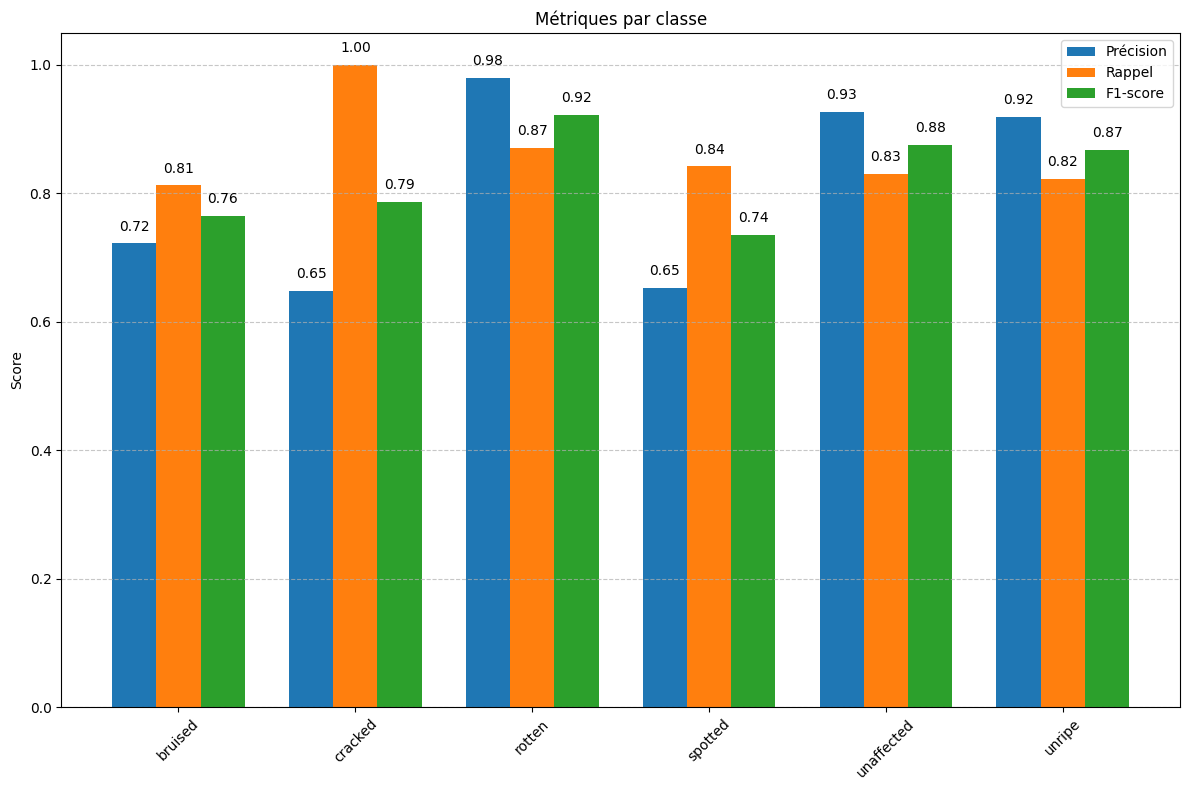

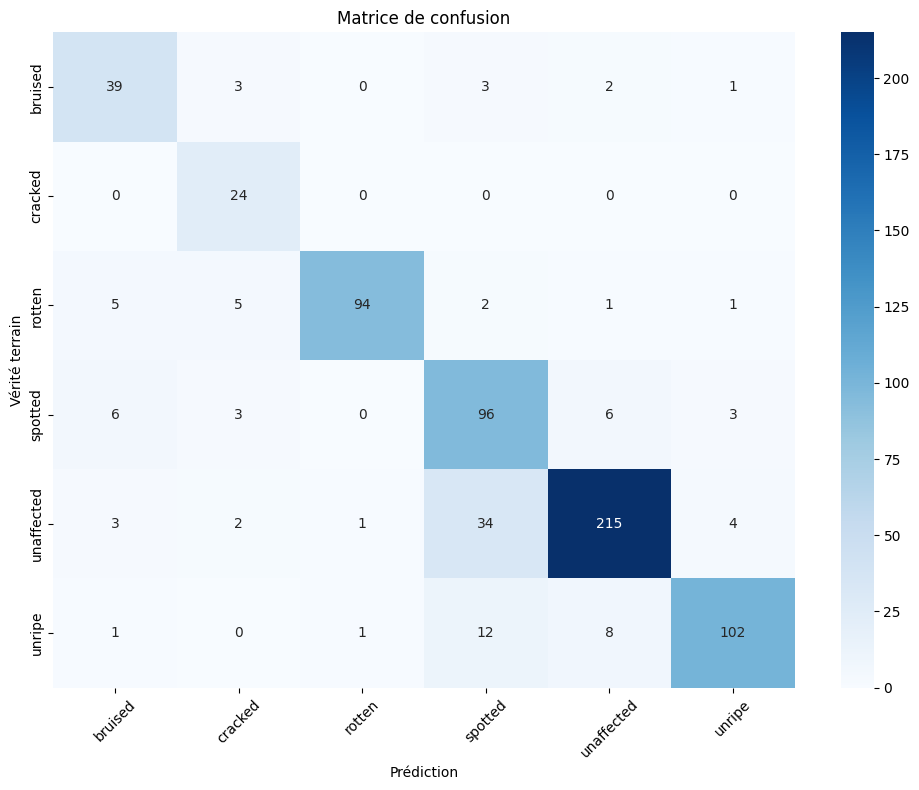

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Charger le meilleur modèle
model.load_weights('best_plum_model.h5')

# Prédire sur l'ensemble de test
y_pred = []
y_true = []

# Réinitialiser le générateur
test_generator.reset()

# Récupérer les prédictions pour l'ensemble de test complet
for i in range(len(test_generator)):
    if i >= test_generator.samples // BATCH_SIZE + (1 if test_generator.samples % BATCH_SIZE > 0 else 0):
        break
    X, y = next(test_generator)
    y_pred.extend(np.argmax(model.predict(X), axis=1))
    y_true.extend(np.argmax(y, axis=1))

# Obtenir les noms des classes
class_names = list(test_generator.class_indices.keys())

# Générer le rapport de classification
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# Afficher la précision, le rappel et le F1-score pour chaque classe
print("Précision par classe:")
for cls_name, metrics in report.items():
    if cls_name in class_names:
        print(f"{cls_name}:")
        print(f"  - Précision: {metrics['precision']:.4f}")
        print(f"  - Rappel: {metrics['recall']:.4f}")
        print(f"  - F1-score: {metrics['f1-score']:.4f}")
        print(f"  - Support: {metrics['support']} échantillons")
        print()

# Visualisation sous forme de graphique
plt.figure(figsize=(12, 8))
classes = list(report.keys())[:len(class_names)]
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))
width = 0.25

plt.bar(x - width, precision, width, label='Précision')
plt.bar(x, recall, width, label='Rappel')
plt.bar(x + width, f1_score, width, label='F1-score')

plt.ylabel('Score')
plt.title('Métriques par classe')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajouter les valeurs sur chaque barre
for i, v in enumerate(precision):
    plt.text(i - width, v + 0.02, f'{v:.2f}', ha='center')
for i, v in enumerate(recall):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center')
for i, v in enumerate(f1_score):
    plt.text(i + width, v + 0.02, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('class_metrics.png', dpi=300)
plt.show()

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion')
plt.ylabel('Vérité terrain')
plt.xlabel('Prédiction')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('confusion_matrix_detailed.png', dpi=300)
plt.show()

# <h3 align = "center">precision sur chaque classse</h3>

In [28]:
# Calculer directement la précision par classe à partir de la matrice de confusion
precision_per_class = np.diag(cm) / np.sum(cm, axis=0)

# Afficher la précision par classe
print("\nPrécision calculée directement pour chaque classe:")
for i, cls_name in enumerate(class_names):
    print(f"{cls_name}: {precision_per_class[i]:.4f}")

# Afficher le nombre d'échantillons correctement classifiés par classe
print("\nNombre d'échantillons correctement classifiés par classe:")
for i, cls_name in enumerate(class_names):
    print(f"{cls_name}: {cm[i, i]} sur {np.sum(cm[i, :])} échantillons")


Précision calculée directement pour chaque classe:
bruised: 0.7222
cracked: 0.6486
rotten: 0.9792
spotted: 0.6531
unaffected: 0.9267
unripe: 0.9189

Nombre d'échantillons correctement classifiés par classe:
bruised: 39 sur 48 échantillons
cracked: 24 sur 24 échantillons
rotten: 94 sur 108 échantillons
spotted: 96 sur 114 échantillons
unaffected: 215 sur 259 échantillons
unripe: 102 sur 124 échantillons


1/1 [==============================] - 0s 75ms/step


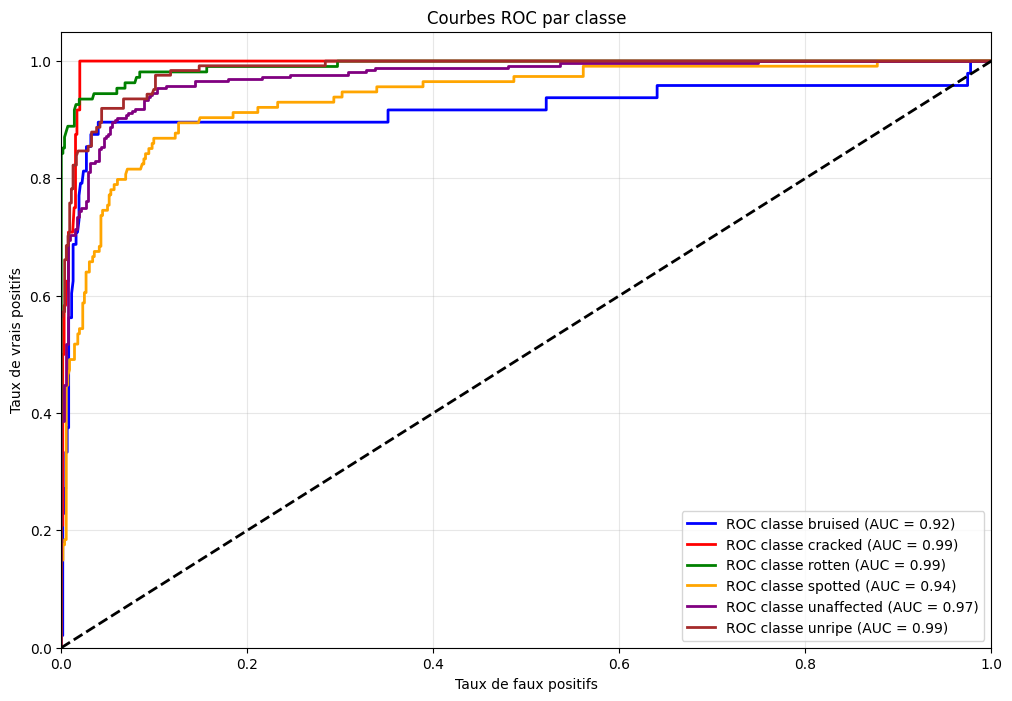

In [29]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Récupérer les probabilités prédites
y_pred_proba = []
test_generator.reset()
for i in range(len(test_generator)):
    if i >= test_generator.samples // BATCH_SIZE + (1 if test_generator.samples % BATCH_SIZE > 0 else 0):
        break
    X, y = next(test_generator)
    y_pred_proba.extend(model.predict(X))

y_pred_proba = np.array(y_pred_proba)
y_test_onehot = to_categorical(y_true, num_classes=len(class_names))

# Tracer les courbes ROC pour chaque classe
plt.figure(figsize=(12, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'brown'])
for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(y_test_onehot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'ROC classe {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC par classe')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('roc_curves.png', dpi=300)
plt.show()